### Script reads from fft and mfcc files and trains using logistic regression and knn
* Author: Geunsik Lim <leemgs@gmail.com> 
* IN: Paths to directories consisting of FFT files, and MFCC files.
* OUT: Splits dataset as per code into train and test sets, performs training and tests. Displays classification accuracy along with confusion matrix.
* Run instructions:  $ python train-classify.py path_dir1 path_dir2 
* Note: 
1. Where path_dir1 is the base_dir that consists of subdirs consisting of fft files. path_dir2 is the base-dir that consists of subdirs consisting of mfcc files.
2. Use ONLY absolute paths. 


In [1]:
import sklearn 
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import scipy
import os
import sys
import glob
import numpy as np


Reads FFT-files and prepares X_train and y_train. genre_list must consist of names of folders/genres consisting of the required FFT-files. base_dir must contain genre_list of directories

In [2]:

def read_fft(genre_list, base_dir):
	X = []
	y = []
	for label, genre in enumerate(genre_list):
		# create UNIX pathnames to id FFT-files.
		genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
		# get path names that math genre-dir
		file_list = glob.glob(genre_dir)
		for file in file_list:
			fft_features = np.load(file)
			X.append(fft_features)
			y.append(label)
	
	# print(X)
	# print(y)
	# print(len(X))
	# print(len(y))

	return np.array(X), np.array(y)


Rreads MFCC-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required MFCC-files
base_dir must contain genre_list of directories

In [3]:

def read_ceps(genre_list, base_dir):
	X, y = [], []
	for label, genre in enumerate(genre_list):
		for fn in glob.glob(os.path.join(base_dir, genre, "*.ceps.npy")):
			ceps = np.load(fn)
			num_ceps = len(ceps)
			X.append(np.mean(ceps[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0))
			y.append(label)
	
	return np.array(X), np.array(y)

In [4]:
def train_score(classifier, Xtrain, Xtest, ytrain, ytest):
        train_acc = classifier.score(Xtrain, ytrain)
        test_acc = classifier.score(Xtest, ytest)
        print("Training Data Accuracy: %0.2f" % (train_acc))
        print("Test Data Accuracy:     %0.2f" % (test_acc))
        ypred = classifier.predict(Xtest)
        conf = confusion_matrix(ytest, ypred)
        precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
        recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
        f1_score = 2 * ((precision * recall)/(precision + recall))
        print("Precision:              %0.2f" % precision)
        print("Recall:                 %0.2f" % recall)
        print("F1 Score:                 %0.2f" % f1_score)
        print('\n')


In [5]:
def learn_and_classify(X_train, y_train, X_test, y_test, genre_list):

	# print("X_train = " + str(len(X_train)), "y_train = " + str(len(y_train)), "X_test = " + str(len(X_test)), "y_test = " + str(len(y_test)))

        #  Method 1: Logistic Regression
	logistic_classifier = linear_model.LogisticRegression()
	logistic_classifier.fit(X_train, y_train)

	logistic_predictions = logistic_classifier.predict(X_test)
	logistic_accuracy = accuracy_score(y_test, logistic_predictions)
	logistic_cm = confusion_matrix(y_test, logistic_predictions)
	print("logistic accuracy = " + str(logistic_accuracy))
	print("logistic_cm:")
	print(logistic_cm)

	
	print("######## [F1-SCORE] CLASSIFICATION REPORT with Logistic Regression ########")
	target_names = ['classical', 'hiphop', 'jazz', 'metal', 'pop', 'rock']
	print(classification_report(y_test, logistic_predictions,target_names=target_names))
	
	plot_confusion_matrix(logistic_cm, "Confusion matrix", genre_list)
	
	#  Method 2: KNeighbors Classifier
	knn_classifier = KNeighborsClassifier()
	knn_classifier.fit(X_train, y_train)
	knn_predictions = knn_classifier.predict(X_test)
	knn_accuracy = accuracy_score(y_test, knn_predictions)
	knn_cm = confusion_matrix(y_test, knn_predictions)
	print("knn accuracy = " + str(knn_accuracy))
	print("knn_cm:") 
	print(knn_cm)
	
	print("######## [F1-SCORE] CLASSIFICATION REPORT with KNeighbors Classifier ########")
	target_names = ['classical', 'hiphop', 'jazz', 'metal', 'pop', 'rock']
	print(classification_report(y_test, logistic_predictions,target_names=target_names))
	
	plot_confusion_matrix(knn_cm, "Confusion matrix for FFT classification", genre_list)

In [6]:
def plot_confusion_matrix(cm, title, genre_list, cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(genre_list))
        plt.xticks(tick_marks, genre_list, rotation=45)
        plt.yticks(tick_marks, genre_list)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [7]:
def main():
	# first command line argument is the base folder that consists of the fft files for each genre
	base_dir_fft  = sys.argv[1]
	# second command line argument is the base folder that consists of the mfcc files for each genre
	base_dir_mfcc = sys.argv[2]

        if base_dir_fft == "":
	        base_dir_fft  = "genres.FFT/"
        if base_dir_mfcc == "":
	        base_dir_mfcc = "genres.MFCC/"
                	
	"""list of genres (these must be folder names consisting .wav of respective genre in the base_dir)
	Change list if needed.
	"""
	genre_list = ["classical", "hiphop", "jazz", "pop", "rock", "metal"]
	
	#genre_list = ["classical", "jazz"] IF YOU WANT TO CLASSIFY ONLY CLASSICAL AND JAZZ

	# use FFT
	X, y = read_fft(genre_list, base_dir_fft)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

	# print("X_train = " + str(len(X_train)), "y_train = " + str(len(y_train)), "X_test = " + str(len(X_test)), "y_test = " + str(len(y_test)))
	
	print('\n******USING FFT******')
	learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
	print('*********************\n')

	# use MFCC
	X, y = read_ceps(genre_list, base_dir_mfcc)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
	print('******USING MFCC******')
	learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
	print('*********************')

# if __name__ == "__main__":
# main()

In [8]:
# Main Routine
base_dir_fft  = "genres.FFT/"
base_dir_mfcc = "genres.MFCC/"


In [9]:
#list of genres (these must be folder names consisting .wav of respective genre in the base_dir) Change list if needed.
#genre_list = ["classical", "jazz"] IF YOU WANT TO CLASSIFY ONLY CLASSICAL AND JAZZ
genre_list = ["classical", "hiphop", "jazz", "pop", "rock", "metal"]



******USING FFT******


/var/www/invain/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/var/www/invain/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logistic accuracy = 0.44
logistic_cm:
[[17  1  3  0  0  1]
 [ 5  8  2  6  5  2]
 [10  1 10  2  3  0]
 [ 3  3  3 12  2  4]
 [ 2  2  5  3 10  5]
 [ 1  2  2  2  4  9]]
######## [F1-SCORE] CLASSIFICATION REPORT with Logistic Regression ########
              precision    recall  f1-score   support

   classical       0.45      0.77      0.57        22
      hiphop       0.47      0.29      0.36        28
        jazz       0.40      0.38      0.39        26
       metal       0.48      0.44      0.46        27
         pop       0.42      0.37      0.39        27
        rock       0.43      0.45      0.44        20

   micro avg       0.44      0.44      0.44       150
   macro avg       0.44      0.45      0.43       150
weighted avg       0.44      0.44      0.43       150



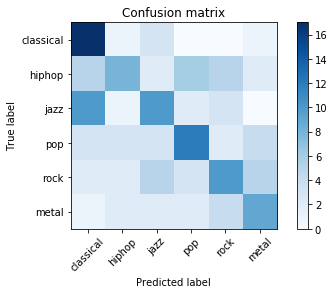

knn accuracy = 0.3
knn_cm:
[[20  1  1  0  0  0]
 [ 3  7  0  7  2  9]
 [17  2  3  0  1  3]
 [ 5  8  1  6  4  3]
 [ 7  4  5  0  2  9]
 [ 1 10  1  0  1  7]]
######## [F1-SCORE] CLASSIFICATION REPORT with KNeighbors Classifier ########
              precision    recall  f1-score   support

   classical       0.45      0.77      0.57        22
      hiphop       0.47      0.29      0.36        28
        jazz       0.40      0.38      0.39        26
       metal       0.48      0.44      0.46        27
         pop       0.42      0.37      0.39        27
        rock       0.43      0.45      0.44        20

   micro avg       0.44      0.44      0.44       150
   macro avg       0.44      0.45      0.43       150
weighted avg       0.44      0.44      0.43       150



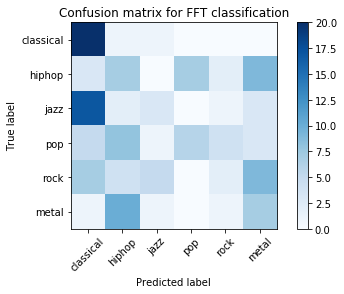

*********************



In [10]:
# use FFT
X, y = read_fft(genre_list, base_dir_fft)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

# print("X_train = " + str(len(X_train)), "y_train = " + str(len(y_train)), "X_test = " + str(len(X_test)), "y_test = " + str(len(y_test)))

print('\n******USING FFT******')
learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
print('*********************\n')


******USING MFCC******
logistic accuracy = 0.7066666666666667
logistic_cm:
[[18  0  1  0  2  2]
 [ 0 12  0  2  6  2]
 [ 3  5 12  0  4  0]
 [ 0  2  0 28  2  0]
 [ 0  2  1  1 14  3]
 [ 0  6  0  0  0 22]]
######## [F1-SCORE] CLASSIFICATION REPORT with Logistic Regression ########
              precision    recall  f1-score   support

   classical       0.86      0.78      0.82        23
      hiphop       0.44      0.55      0.49        22
        jazz       0.86      0.50      0.63        24
       metal       0.90      0.88      0.89        32
         pop       0.50      0.67      0.57        21
        rock       0.76      0.79      0.77        28

   micro avg       0.71      0.71      0.71       150
   macro avg       0.72      0.69      0.70       150
weighted avg       0.74      0.71      0.71       150



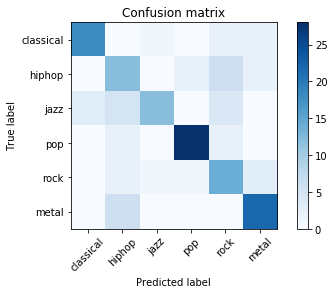

knn accuracy = 0.7266666666666667
knn_cm:
[[18  0  1  1  1  2]
 [ 0 10  4  3  3  2]
 [ 5  2 13  0  4  0]
 [ 0  1  1 30  0  0]
 [ 0  1  1  1 17  1]
 [ 0  5  0  0  2 21]]
######## [F1-SCORE] CLASSIFICATION REPORT with KNeighbors Classifier ########
              precision    recall  f1-score   support

   classical       0.86      0.78      0.82        23
      hiphop       0.44      0.55      0.49        22
        jazz       0.86      0.50      0.63        24
       metal       0.90      0.88      0.89        32
         pop       0.50      0.67      0.57        21
        rock       0.76      0.79      0.77        28

   micro avg       0.71      0.71      0.71       150
   macro avg       0.72      0.69      0.70       150
weighted avg       0.74      0.71      0.71       150



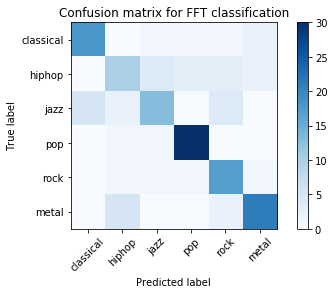

*********************


In [11]:
# use MFCC
X, y = read_ceps(genre_list, base_dir_mfcc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print('******USING MFCC******')
learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
print('*********************')